# Basic McCall Model

In [1]:
n = 10                                   #Number of possible outcomes for wage
w_vec = collect(linspace(10,100,n))      #Vector of possible wage draws between 10 and 20
p_vec = collect(linspace(1/n,1/n,n))     #Probability of drawing each wage is equal
P = repmat(p_vec,1,n)                    #Transition matrix 


beta = 0.96                  #Discount factor
c = 10                       #Value of unemployment insurance

V = ones(n)                  #Initial guess of value of each wage is one 
V_new = similar(V)           #n x 1 vector to store new value function (see below)

VT = V                       #VT stores all iterations of the value function


Accept = w_vec/(1-beta)      #Vector containing PDV of accepting each wage (worker earns the wage forever)


# VALUE FUNCTION ITERATION FOR MCCALL MODEL

tol = 1e-8
maxiter = 2000
err = 1
i=0

while err > tol && i < maxiter
    V_new = max.(Accept, c+beta*P*V)       #NOTE: the i-th element of V_new is the max of the PDV of accepting a given wage and the PDV of rejecting (i.e. V_new stores the PDV of drawing the i-th wage) 
    
    VT = hcat(VT,V_new)                    #Add V_new to VT
    
    err = maximum(abs,V_new - V)
    V = V_new
    i += 1
end


Lets plot the value function


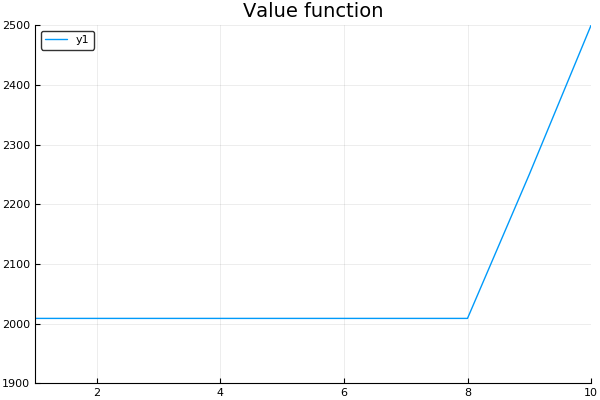

In [37]:
using Plots
Plots.pyplot()
plot(V,yticks=0:100:2500,title="Value function")
ylims!((1900,2500))

Lets check out how the value function converges


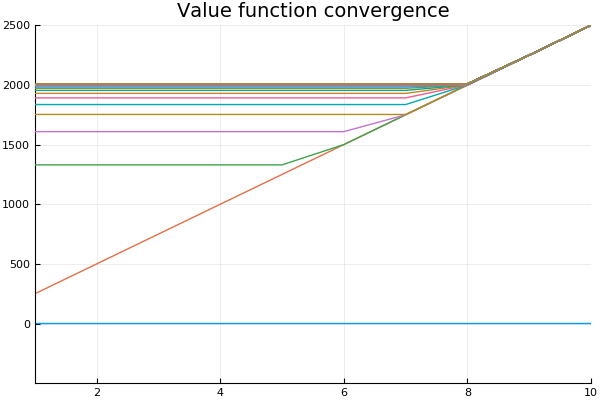

In [36]:
plot(VT,yticks=0:500:2500,title="Value function convergence",legend=:none)
ylims!((-500,2500))

# Varying the Parameters of the Model

Next let's play around with the parameters of the model and examine the effect on the V's and reservation wages.

In [18]:
V_base = V;             #Store V with the baseline parameterization

## Varying the discount factor, $\beta$

In [19]:
function mcbellman(c,beta,tol = 1e-8,maxiter = 2000,err = 1,i=0) 
    
    V = ones(n)                  #Initial guess of value of each wage is one 
    V_new = similar(V)           #n x 1 vector to store new value function (see below)

    VT = V                       #VT stores all iterations of the value function


    Accept = w_vec/(1-beta)      #Vector containing PDV of accepting each wage (worker earns the wage forever)
    
    while err > tol && i < maxiter
        V_new = max.(Accept, c+beta*P*V)       #NOTE: the i-th element of V_new is the max of the PDV of accepting a given wage and the PDV of rejecting (i.e. V_new stores the PDV of drawing the i-th wage) 
        
        VT = hcat(VT,V_new)                    #Add V_new to VT
    
        err = maximum(abs,V_new - V)
        V = V_new
        i += 1
    end
    return V 
end;

In [20]:
V_beta1=mcbellman(10,0.95);

In [21]:
V_beta2=mcbellman(10,0.97);

In [22]:
Vcomb=hcat(V_base,V_beta1,V_beta2);


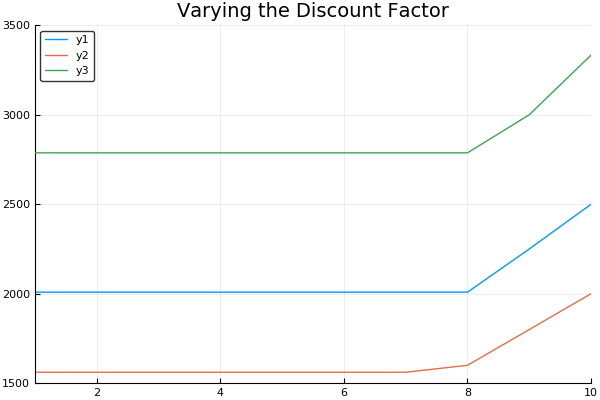

In [38]:
using Plots
plot(Vcomb,title="Varying the Discount Factor")
ylims!((1500,3500))

The above graph plots the value functions for different values of $\beta$, holding $c$ constant at 10. The blue line is our baseline parameterization, $\beta = 0.96$; the orange line corresponds to $\beta=0.95$ and the green line corresponds to $\beta=0.97$. As expected, a reduction in $\beta$ (i.e. the worker becomes more 'impacient') leads to a lower reservation wage. An increase in $\beta$ would also lead to a higher reservation wage in an example where the wage was a continuous random variable. Furthermore, a lower $\beta$ results in a lower V at each wage level.

## Varying the value of unemployment insurance, $c$

Next, we'll see what happens when we play with the level of $c$, holding $\beta$ constant at 0.90. 

In [39]:
V_c1=mcbellman(10,0.90)
V_c2=mcbellman(40,0.90)
V_c3=mcbellman(80,0.90)
Vcomb=hcat(V_c1,V_c2,V_c3);


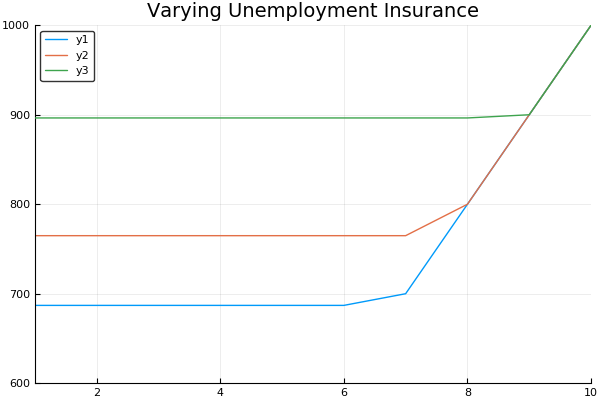

In [42]:
plot(Vcomb,title="Varying Unemployment Insurance")
ylims!((600,1000))

In the above graph the blue line corresponds to $c=10$, the orange line corresponds to $c=40$, while the green line corresponds to $c=80$. As expected, the reservation wage and overall level of V, increases with $c$.

## Varying the wage density

In the baseline example we assumed that each wage was drawn with equal probability (0.1). Let's see what happens when we assume that the wage has a beta-binomial distribution.

In [43]:
using Distributions
dist = BetaBinomial(n-1, 600, 400);

In [44]:
p_vec_hat = pdf.(dist,support(dist))'
P = repmat(p_vec_hat,n,1);

In [45]:
w=rand(BetaBinomial(n-1, 600, 400),500);


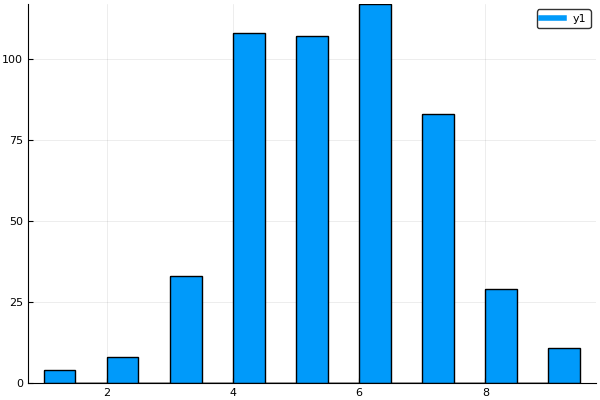

In [46]:
histogram(w)

So, under this distribution, mid-level wages are most likely to be drawn. 

In [47]:
function mcbellmanp(c,beta,tol = 1e-8,maxiter = 2000,err = 1,i=0) 
    
    
    #ASSUMING WAGES FOLLOW A BETA-BINOMIAL DISTRIBUTION
    w_vec = collect(linspace(10,100,n))
    dist = BetaBinomial(n-1, 600, 400)
    p_vec_hat = pdf.(dist,support(dist))'
    P = repmat(p_vec_hat,n,1) 
    
    
    V = ones(n)                  #Initial guess of value of each wage is one 
    V_new = similar(V)           #n x 1 vector to store new value function (see below)

    VT = V                       #VT stores all iterations of the value function


    Accept = w_vec/(1-beta)      #Vector containing PDV of accepting each wage (worker earns the wage forever)
    
    while err > tol && i < maxiter
        V_new = max.(Accept, c+beta*P*V)       #NOTE: the i-th element of V_new is the max of the PDV of accepting a given wage and the PDV of rejecting (i.e. V_new stores the PDV of drawing the i-th wage) 
        
        VT = hcat(VT,V_new)                    #Add V_new to VT
    
        err = maximum(abs,V_new - V)
        V = V_new
        i += 1
    end
    return V 
end;


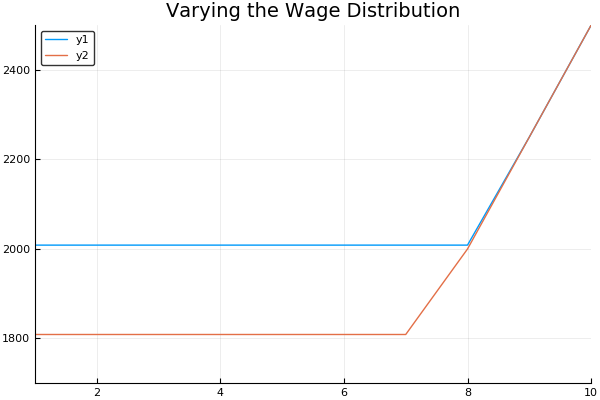

In [52]:
V_bin=mcbellmanp(10,0.96)
Vcomb=hcat(V_base,V_bin)
plot(Vcomb,title="Varying the Wage Distribution")
ylims!((1700,2500))

In the above graph the blue line corresponds to the baseline case, where wages have a discrete uniform distribution. The orange line implements the beta-binomial wage distribution. Thus, changing the wage density from a discrete uniform to the beta-binomial lowers the reservation wage. The interpretation of this change is fairly straightforward: under the uniform distribution, higher wages are more likely to be drawn, compared to the beta-binomial wage distribution; so the worker has more reason to hold out and wait for a higher wage draw under the uniform wage distribution. This outcome is essentially an example of the effect of a mean-preserving increase in risk discussed in class (also see LS p 168).